In [2]:
from fonctionsutiles import *
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from graph import network, name_dic
from random import choices
import igraph as ig

3045
3045
487843


In [3]:
node_num = network.vcount()
step = int(node_num/10)
weight_list = []

val = 1
count = 0
for i in range(node_num):
    count += 1
    weight_list.append(val)
    if count > step:
        count = 0
        val *= 1.3

In [61]:
def reini_dico():
    dico = {}
    for index, row in cleaned_account.iterrows():
            # initialisation of the dictionary with basics caracterisitcs
        dico[name_dic[row.id_user]] = {'total_views': 0,
                            'total_likes': 0,
                            'total_comments': 0,
                            'total_click': 0,
                            'total_donations': 0,
                            'posting': 0, # first number = is posting at this timestamp, second number = will post at the next timestamp)
                            'posted': 0, # 1 if the user already posted something, turns back to 0 after a while (so that the user can post again)
                            'iterations_since_post':0,
                            'influenciability' : 1, #choices([1,2,3], weights=(30,20,10), k=1)[0],
                            'seuil_repost' : int(np.random.uniform(0,50)),
                            'nb_followers' : int(row.nb_followers)
                            }  # Parameters we consider have an impact on the post propagation
    return dico

In [5]:
def score(network,dico):
    # Donne le score global des individus dans le réseau
    
    score_dic = {}
    for user in dico:
        s = 0
        user_d = dico[user]
        
        view = user_d['total_views']
        likes = user_d['total_likes']
        comm = user_d['total_comments']
        click = user_d['total_click']
        donate = user_d['total_donations']
        inf = user_d['influenciability']
        
        s += view + 20*likes + 200*comm + 400*click + 4000 * donate + inf
        s *= (inf+1)/2
        
        score_dic[user] = s
    return score_dic

In [89]:
def action_number(poster,dico):
    # Returns a dictionnary of the number of persons doing each action
    action_dic = {'view': 0, 'like': 0, 'comment': 0, 'click': 0, 'donate':0}
        
    followers = dico[poster]['nb_followers']
    
    
    nb_views = followers*np.random.exponential(1/1.2, 1)[0]/1.2
    nb_likes = followers*np.random.exponential(1/6, 1)[0]/6
    nb_comments = followers*np.random.exponential(1/30, 1)[0]/30
    nb_clicks = np.random.binomial(nb_views, 320/251167)
    # nb_donate = np.random.binomial(nb_views, 31/251167)

    action_dic['view'] = int(nb_views)
    action_dic['like'] = int(nb_likes)
    action_dic['comment'] = int(nb_comments)
    action_dic['click'] = int(nb_clicks)
    # action_dic['donate'] = int(nb_donate)

    
    return action_dic
    
   

def post_rank(graph,poster,score_dic):    
    # Ajoute le score propre à la relation de follow et trie la liste
    for key in score_dic:
        score = score_dic[key]
        if graph.are_connected(int(key),int(poster)):
            score *= 2
        score_dic[key] = score
    return sorted(score_dic, key=score_dic.get, reverse=True)
    


def choose(action_dic,rank_lst):
    # Outputs the choice dictionnary where a list reprensetns the user_ids that will do the actions
    choice_dic = {'view': [], 'like': [], 'comment': [], 'click': [], 'donate':[]}
    for key in choice_dic:
        if key != 'donate' :
            choice_dic[key] = choices(rank_lst,weights = weight_list,k = action_dic[key])
        else:
            click_lst = choice_dic['click']
            donate = []
            for clicker in click_lst:
                flip = choices([0,1],weights = [0.9,0.1],k = 1)[0]
                if flip == 1:
                    donate.append(clicker)
            choice_dic[key] = donate
    return choice_dic

def action_update(choice_dic,dico):
    
    #vues:
    for id in choice_dic['view']:
        dico[id]['total_views']+=1
    #like:
    for id in choice_dic['like']:
        dico[id]['total_likes']+=1
    #comment:
    for id in choice_dic['comment']:
        dico[id]['total_comments']+=1
    #click:
    for id in choice_dic['click']:
        dico[id]['total_click']+=1
    #dons:
    for id in choice_dic['donate']:
        dico[id]['total_donations']+=1
    # Updates the values of the dictionnary absed on the actions done (changes second value of tuple)
    # Returns nothing
    return dico

In [7]:
def post(poster,network,scores,dico):
    # Variables : vertex id, the graph, a score dictionnary, the global dictionnary
    
    action_dic = action_number(poster,dico)
    rank_lst = post_rank(network,poster,scores)
    choice_dic= choose(action_dic, rank_lst)
    dico = action_update(choice_dic,dico)
    
    return dico

In [8]:
def update(dico,g):
    #Prend en argument le dictionnaire de personnes à un instant et le réseau et fait le pas de temps suivant
    general_score = score(g,dico)       #dictionnaire avec id en clé et score en valeur
    for person in dico:
        if dico[person]['posting'] == 1:
            dico = post(person,g,general_score,dico)
    
    for key in dico:
        if dico[key]['posting'] == 1:
            dico[key]['posting'] = 0
            dico[key]['posted'] = 1
        elif (dico[key]['seuil_repost'] < dico[key]['total_views']) and (dico[key]['posted'] != 1):
            dico[key]['posting'] = 1

def posts_initiaux(dico, listeid):
    for id in listeid:
        dico[id]['posting']=1
    return

In [94]:
dico = reini_dico()

posts_initiaux(dico,[name_dic[483543],name_dic[672702],name_dic[587566],name_dic[474227]])

V = []
L = []    
Co = []
CL = []
D = []
Repost = []

for t in range(15):
    num = 0
    for key in dico:
        num += dico[key]['posting'] 
    Repost.append(num)
        
    update(dico,network)
    
for key in dico:
    V.append(dico[key]['total_views'])
    L.append(dico[key]['total_likes'])
    Co.append(dico[key]['total_comments'])
    CL.append(dico[key]['total_click'])
    D.append(dico[key]['total_donations'])


[4, 4, 6, 11, 26, 57, 129, 401, 850, 1232, 316, 5, 0, 0, 0]
3041


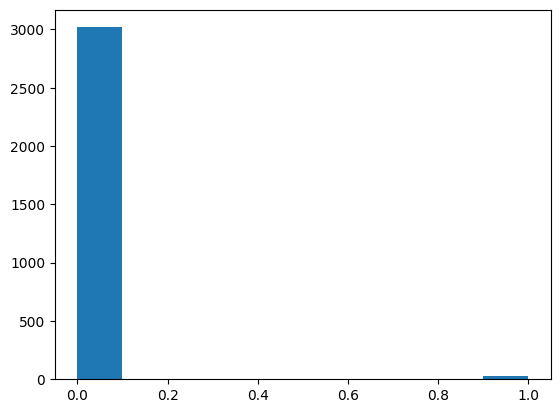

417
23


In [103]:
print(Repost)
print(sum(Repost))
plt.hist(Co)

plt.show()
print(sum(CL))

print(sum(D))